In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import xgboost as xgb
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

cols = [' Bwd Packet Length Std',' PSH Flag Count',' min_seg_size_forward',' Min Packet Length',' ACK Flag Count',' Bwd Packet Length Min',' Fwd IAT Std','Init_Win_bytes_forward',' Flow IAT Max',' Bwd Packets/s',' URG Flag Count','Bwd IAT Total',' Label']
df1=pd.read_csv("IDS1.csv", usecols = cols)#,nrows = 50000
df2=pd.read_csv("IDS2.csv", usecols = cols)
df3=pd.read_csv("IDS3.csv", usecols = cols)
df4=pd.read_csv("IDS4.csv", usecols = cols)
df5=pd.read_csv("IDS5.csv", usecols = cols)
df6=pd.read_csv("IDS6.csv", usecols = cols)
df7=pd.read_csv("IDS7.csv", usecols = cols)
df8=pd.read_csv("IDS8.csv", usecols = cols)

df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6

data = df.copy()

In [15]:
for column in data.columns:
    if data[column].dtype == np.int64:
        maxVal = data[column].max()
        if maxVal < 120:
            data[column] = data[column].astype(np.int8)
        elif maxVal < 32767:
            data[column] = data[column].astype(np.int16)
        else:
            data[column] = data[column].astype(np.int32)
            
    if data[column].dtype == np.float64:
        maxVal = data[column].max()
        minVal = data[data[column]>0][column]
        if maxVal < 120 and minVal>0.01 :
            data[column] = data[column].astype(np.float16)
        else:
            data[column] = data[column].astype(np.float32)
            
            

attackType = data[' Label'].unique()
data[' Label'] = data[' Label'].astype('category')
data[' Label'] = data[' Label'].astype("category").cat.codes

In [19]:
y = data[' Label'].copy()
X = data.drop([' Label'],axis=1)
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(X, y)

In [20]:
df = X_rus
df[' Label'] = y_rus
minor = pd.DataFrame(df[(df[' Label']!=4) & (df[' Label']!=2)])
major = pd.DataFrame(df[(df[' Label']==4) | (df[' Label']==2)])
minor[' Label'].value_counts()

 Label
1    1966
5    1507
7     652
3      36
0      21
6      21
Name: count, dtype: int64

In [21]:
from imblearn.over_sampling import SMOTE
y_rus_ =  minor[' Label']
X_rus_ =  minor.drop([' Label'],axis=1)
strategy = {1:2000, 5:1600, 7:800, 3:300, 6:200, 0:200}
sm = SMOTE(sampling_strategy=strategy)
X_sm, y_sm = sm.fit_resample(X_rus_, y_rus_)
X_min,y_min = X_sm, y_sm 

In [22]:
from imblearn.under_sampling import RandomUnderSampler
y_rus_ =  major[' Label']
X_rus_ =  major.drop([' Label'],axis=1)
strategy = {4:10000, 2:6000}
tom = RandomUnderSampler(sampling_strategy=strategy)
X_tom, y_tom = tom.fit_resample(X_rus_, y_rus_)
y_tom.value_counts()

 Label
4    10000
2     6000
Name: count, dtype: int64

In [23]:
X_maj,y_maj = X_tom, y_tom
X,y = pd.concat([X_maj,X_min]), pd.concat([y_maj,y_min])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21100 entries, 79326 to 5099
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0    Bwd Packet Length Min  21100 non-null  int16  
 1    Bwd Packet Length Std  21100 non-null  float32
 2    Flow IAT Max           21100 non-null  int32  
 3    Fwd IAT Std            21100 non-null  float32
 4   Bwd IAT Total           21100 non-null  int32  
 5    Bwd Packets/s          21100 non-null  float32
 6    Min Packet Length      21100 non-null  int16  
 7    PSH Flag Count         21100 non-null  int8   
 8    ACK Flag Count         21100 non-null  int8   
 9    URG Flag Count         21100 non-null  int8   
 10  Init_Win_bytes_forward  21100 non-null  int32  
 11   min_seg_size_forward   21100 non-null  int8   
dtypes: float32(3), int16(2), int32(3), int8(4)
memory usage: 824.2 KB


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = X.select_dtypes(include=['float32','float16','int32','int16','int8']).columns
train_X = scaler.fit_transform(X.select_dtypes(include=['float32','float16','int32','int16','int8']))


from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(train_X,y,train_size=0.70, random_state=2)

In [25]:
df = pd.concat([X, y], axis=1)

# Export the DataFrame to a CSV file
df.to_csv('output.csv', index=False) 

In [26]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost model for multiclass classification
model = xgb.XGBClassifier(
    n_estimators=100,            # Number of boosting rounds
    learning_rate=0.1,           # Step size at each iteration
    max_depth=6,                 # Maximum depth of the tree
    objective='multi:softmax',   # Multiclass classification
    num_class=3,                 # Set the number of classes (replace with your number of classes)
    eval_metric='mlogloss',      # Log loss for multiclass
    use_label_encoder=False      # Avoid label encoder warning
)

# Train the model using the entire dataset
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (Precision, Recall, F1-Score for each class)
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Confusion matrix (how well the model predicts each class)
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))


Accuracy: 0.9673

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       200
           1       1.00      1.00      1.00      2000
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00       300
           4       1.00      1.00      1.00     10000
           5       0.72      0.93      0.81      1600
           6       0.99      0.98      0.99       200
           7       0.68      0.28      0.39       800

    accuracy                           0.97     21100
   macro avg       0.92      0.90      0.90     21100
weighted avg       0.97      0.97      0.96     21100


Confusion Matrix:
[[ 199    1    0    0    0    0    0    0]
 [   0 2000    0    0    0    0    0    0]
 [   0    0 6000    0    0    0    0    0]
 [   0    0    0  300    0    0    0    0]
 [   0    0    0    0 9998    0    1    1]
 [   0    0    0    0    0 1495    1  104]
 [   0    0    0    0    0    3

In [27]:
# Check the unique attack labels
print(y.unique())


[2 4 0 1 3 5 6 7]


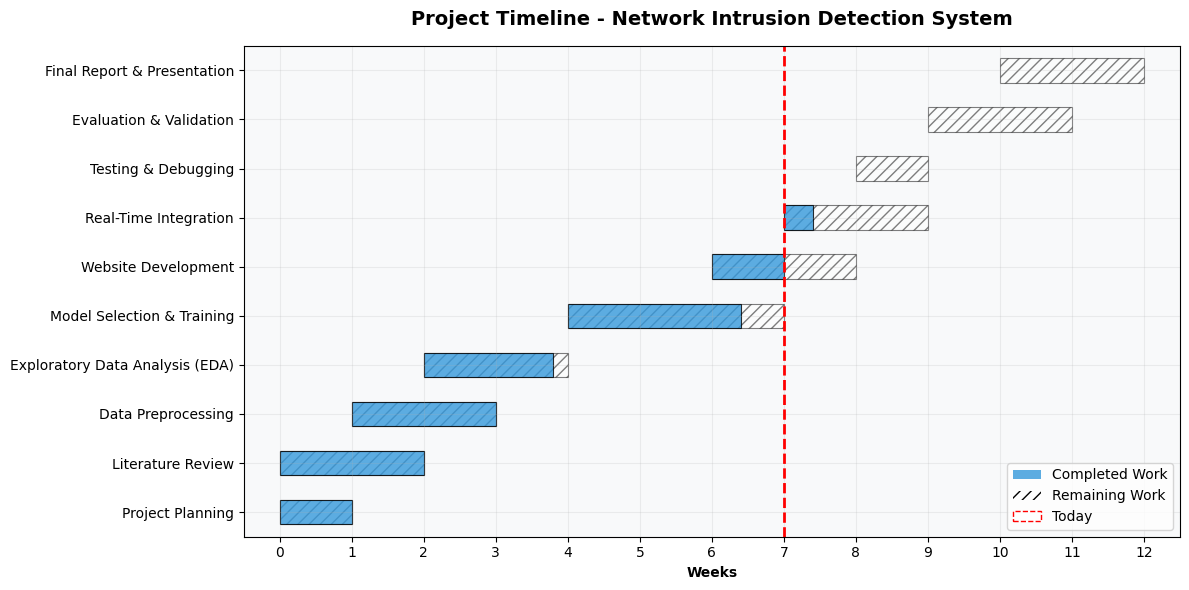

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def create_gantt_chart(tasks, start_times, durations, progress=None, today=None, 
                       color='#3498db', fig_size=(12, 6), title="Project Gantt Chart"):
    """
    Create a professional Gantt chart with progress indicators, patterns for remaining work, and a legend.
    
    Parameters:
    -----------
    tasks : list
        List of task names
    start_times : list
        List of start times (in weeks from project start)
    durations : list
        List of task durations (in weeks)
    progress : list, optional
        List of completion percentages (0-100) for each task
    today : float, optional
        Current time point to show a vertical line (in weeks from project start)
    color : str, optional
        Base color for task bars
    fig_size : tuple, optional
        Figure size (width, height) in inches
    title : str, optional
        Chart title
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=fig_size)
    y_positions = range(len(tasks))
    
    # Create a grid with 1-week intervals
    max_end_time = max([s + d for s, d in zip(start_times, durations)])
    ax.set_xticks(np.arange(0, max_end_time + 1, 1))
    ax.grid(True, axis='both', linestyle='-', alpha=0.2)  # Both x and y grid
    
    # Plot task bars with patterns for remaining work
    for i, (task, start, duration) in enumerate(zip(tasks, start_times, durations)):
        # Draw the full task bar with pattern
        bar = ax.barh(i, duration, left=start, height=0.5, 
                      color='white', edgecolor='black', linewidth=0.8,
                      hatch='///', alpha=0.5)
        
        # Overlay progress if available
        if progress is not None and i < len(progress):
            prog = progress[i]
            if prog > 0:
                progress_width = duration * (prog / 100)
                ax.barh(i, progress_width, left=start, height=0.5, 
                        color=color, alpha=0.8, edgecolor='black', linewidth=0.8)
        
        # Add task duration label
        # ax.text(start + duration/2, i, f"{duration}w", 
        #         ha='center', va='center', color='black', fontweight='bold')
    
    # Add today indicator
    if today is not None:
        ax.axvline(x=today, color='red', linestyle='--', linewidth=2)
        # ax.text(today, len(tasks) + 0.3, 'Today', color='red', ha='center', fontweight='bold')
    
    # Set y-axis labels and limits
    ax.set_yticks(y_positions)
    ax.set_yticklabels(tasks)
    ax.set_ylim(-0.5, len(tasks) - 0.5)
    
    # Set x-axis label and formatting
    ax.set_xlabel('Weeks', fontweight='bold')
    ax.set_xlim(-0.5, max_end_time + 0.5)  # Add some padding
    
    # Background styling
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('white')
    
    # Add title
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor=color, alpha=0.8, label='Completed Work'),
        Patch(facecolor='white', hatch='///', alpha=0.5, label='Remaining Work'),
        Patch(facecolor='white', edgecolor='red', linestyle='--', label='Today')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    # Adjust layout
    plt.tight_layout()
    return fig, ax

# Sample Data
tasks = [
    "Project Planning",
    "Literature Review",
    "Data Preprocessing",
    "Exploratory Data Analysis (EDA)",
    "Model Selection & Training",
    "Website Development",
    "Real-Time Integration",
    "Testing & Debugging",
    "Evaluation & Validation",
    "Final Report & Presentation"
]

start_times = [0, 0, 1, 2, 4, 6, 7, 8, 9, 10]  # Start weeks  
durations = [1, 2, 2, 2, 3, 2, 2, 1, 2, 2]    # Duration in weeks  
progress = [100, 100, 100, 90, 80, 50, 20, 0, 0, 0]  # Completion percentages  

today = 7  # Current progress in weeks  


# Create Gantt chart
fig, ax = create_gantt_chart(
    tasks=tasks,
    start_times=start_times,
    durations=durations,
    progress=progress,
    today=today,
    color='#3498db',  # Keeping all tasks the same color with shading for progress
    title="Project Timeline - Network Intrusion Detection System"
)

plt.show()